In [50]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [51]:
num_data = 3000

def generate_data(num_data):
    # AWGN
    v = 0.1*np.random.normal(0,1,num_data+2) 

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + v[0], d_true[1] + v[1]]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + 0.9*np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + v[i])

    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))
    d_true = d_true[2::]
    d = d[2::]
    return np.array(u), np.array(d),np.array(d_true)
generate_data(num_data)
num_experiments = 1
gauss_kernel = lambda u_i,u_j: np.exp(-3.73 * (np.linalg.norm(u_i - u_j,ord=2)**2))
kernel = gauss_kernel
step_size = 0.09
reg_coeff = 0.03
threshold = 0.5

In [95]:
import numpy as np

def KRLS_RFF(u,d,kernel,l,beta,D):

    err = np.array([])
    W = np.random.normal(loc=0, scale=2.25, size=(2,D))
    b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
    
    # Initalization
    P = np.eye(D)/l
    alpha = np.zeros((D,1))
#     err = np.append(err,d[0] - h.T @ alpha)
    for n in range(int(len(d))):
        u_n = u[n].reshape(2,1)
        d_n = d[n]
        h = np.sqrt(2/D) * np.cos(W.T @ u_n + b)
        err = np.append(err,d_n - h.T @ alpha)
        
        k = (P @ h)/(beta + h.T @ P @ h)
#         print(k.shape)
        P = (P - (k @ h.T @ P))/beta
        alpha = alpha + k * err[-1]
    return err

# Experiment
mse = np.zeros(num_data)

for i in tqdm(range(num_experiments)):
#     print('experiment',i+1)
    u,d,d_true = generate_data(num_data)
    startTime = time.time()
    err = KRLS_RFF(u,d,kernel,0.1,1,25)
    mse = mse + (((d_true - d) + err)**2)/num_experiments

mse_smooth = np.convolve(mse,np.ones(20)/20,'valid')

100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


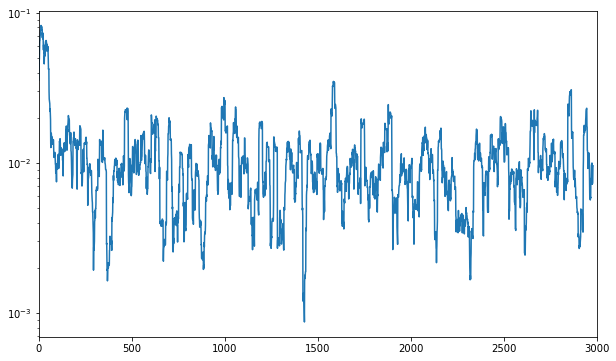

In [96]:
plt.figure(figsize=(10, 6))
plt.semilogy(range(len(mse_smooth)),mse_smooth)
# plt.ylim([1e-2,1e1])
plt.xlim([0,3000])
plt.show()

In [48]:
def KRLS_RFF2(u,d,kernel,l,beta,D):

    err = np.array([])

    W = np.random.normal(loc=0, scale=2.25, size=(2,D))
    b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
    
    # Initalization
    P = np.eye(D)/l
    alpha = np.zeros((D,1))
    for n in range(1, len(d)):
        u_n = u[n].reshape(1,2)
        d_n = d[n]
        k = kernel(u_n,u_n)
        h = np.sqrt(2/D) * np.cos(W.T @ u_n + b)
        a = K_inv @ h
        delta = (k - h.T @ a).item()
        err = np.append(err,d_n - h.T @ alpha)
        if delta > threshold:
            dictionary = np.r_[dictionary, u_n]

            K_inv_num = np.c_[delta*K_inv + a @ a.T,-a]
            K_inv_den = np.c_[-a.T, 1]
            K_inv = np.r_[K_inv_num,K_inv_den]
            K_inv = K_inv/delta

            P_num = np.c_[P,np.zeros((m,1))]
            P_den = np.c_[np.zeros((m,1)).T, 1]
            P = np.r_[P_num,P_den]

            alpha = np.array(alpha - ((a * err[-1])/delta)).reshape(m,1)
            alpha = np.r_[alpha,[[err[-1]/delta]]]
            m = m + 1


        q_t = (P @ a)/(1 + a.T @ P @ a)
        P = P - ((P @ a @ a.T @ P)/(1 + a.T @ P @ a))

        alpha = alpha + K_inv @ q_t * err[-1]

#     print('number of SVs',len(dictionary))
    return err

# Experiment
mse = np.zeros(num_data)

for i in tqdm(range(num_experiments)):
#     print('experiment',i+1)
    u,d,d_true = generate_data(num_data)
    startTime = time.time()
    err = KRLS_RFF2(u,d,kernel,0.1,1,20)
#     mse = mse + (((d_true - d) + err)**2)/num_experiments

# mse_smooth = np.convolve(mse,np.ones(20)/20,'valid')

array([0.0033299 , 0.03037374, 0.00868982, ...,        nan,        nan,
              nan])